<a href="https://colab.research.google.com/github/ShengwenWesley/QAIFS_Stack/blob/main/Mean_Reversion_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [170]:
def get_sp500_constituents():
  """
  Retrieve the consituents for S&P500 index from Wikipedia.

  :Params
    NONE
  :Return
    pd.dataframe with columns Ticker and Company

  """
  tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
  constituents = tables[0]
  constituents = constituents.rename(columns={'Symbol': 'Ticker', 'Security': 'Company'})
  sp500_constituents = constituents.iloc[:,0:2]
  return sp500_constituents

In [171]:
def get_Open_Close_Price(startDate:str = "20/03/23",endDate:str = "21/03/25"):
  """
  :Params
    startDate
    endDate (exclusive)
    *format of "Date/Month/Year" liek "20/03/25" for 2025-03-20

  :Return
    dictionary (key=Ticker,Value=Opeb&Close Price over the period)
  """
  startDate = datetime.strptime(startDate,"%d/%m/%y")
  endDate = datetime.strptime(endDate,"%d/%m/%y")
  dataList = {}

  for currentTicker in SP500_CONSTITUENTS['Ticker']:
    try:
      currentStockData = yf.download(currentTicker, start=startDate, end=endDate)
      currentStockData = currentStockData[['Open','Close']]
      currentStockData.columns = ['Open','Close']
      dataList[currentTicker] = currentStockData
    except:
      # Should have written to the log
      continue
  return dataList

In [172]:
def get_top10drop_stocks(rawData:set):
  """
  :Params
    Dictionary that (key=Ticker,value=Price over periods)
  :Return
    Dictionary that (key=Timestamp,value=Top10 Tickers that drop the most)
  """
  target = {}
  data = pd.DataFrame()
  for currentTicker in rawData.keys():
    data[currentTicker] = rawData[currentTicker]['Close'] - rawData[currentTicker]['Open']
  for i in range(len(data)):
    currentDate = data.index[i]
    currentData = data.iloc[i,:].sort_values(ascending=True)
    target[currentDate] = currentData.index[:10].tolist()
  return target

In [173]:
def calculate_Buy_Amount(currentPortfolio,today,targetTickers,rawData):
  """
  :Params
    currentPortfolio : Money in account
    today : today's date
    targetTickers : the target ticker set for what to buy today
    rawData : the raw data set for today's price
  :Return
    buyAmount : how much can be bought
  """
  buyOneEachCost = 0
  for i in targetTickers[today]:
    buyOneEachCost += rawData[i].loc[today]['Close']
  return currentPortfolio // buyOneEachCost

def buy(currentPortfolio,buyDate,targetTickers,rawData,buyAmount):
  """
  :Params
    currentPortfolio : Money in account
    buyDate : buying in date
    targetTickers : the target ticker set for what to buy today
    rawData : the raw data set for today's price
    buyAmount : how much can be bought
  :Return
    currentPortfolio : Money in account after buying
  """
  for i in targetTickers[buyDate]:
    currentPortfolio -= buyAmount*rawData[i].loc[buyDate]['Close']
  return currentPortfolio

def sell(currentPortfolio,buyDate,sellDate,targetTickers,rawData,sellAmount):
  """
  :Params
    currentPortfolio : Money in account
    buyDate : buying in date
    sellDate : selling out date
    targetTickers : the target ticker set for what to buy today
    rawData : the raw data set for today's price
    sellAmount : how much to sell
  :Return
    currentPortfolio : Money in account after selling
  """
  for i in targetTickers[buyDate]:
    currentPortfolio += sellAmount*rawData[i].loc[sellDate]['Open']
  return currentPortfolio

In [174]:
def get_RoI(initialMoney,rawData:set,targetTickers:set):
  """
  :Params
    initialMoney : The initial Amount of money in account
    rawData : the raw data set for stock prices
    targetTickers : the target ticker set for what to buy each day
  :Return
    RoI : array, Return on Investment,starting from the second day

  """

  Dates = list(targetTickers.keys())
  PeriodsLength = len(Dates)

  yesterday = Dates[0]
  today = Dates[1]
  buyAmount = 0
  Portfolio = initialMoney
  RoI = []

  # Buy on the first date
  buyAmount = calculate_Buy_Amount(Portfolio,yesterday,targetTickers,rawData)
  Portfolio = buy(Portfolio,yesterday,targetTickers,rawData,buyAmount)

  # Sell Yesterdays', record portfolio and buy todays'
  for i in range(1,PeriodsLength-1):
    today = Dates[i]

    # Sell Yesterdays'
    Portfolio = sell(Portfolio,yesterday,today,targetTickers,rawData,buyAmount)

    # Record Portfolio
    RoI.append(float(Portfolio))

    # Calculate amount to buy
    buyAmount = calculate_Buy_Amount(Portfolio,today,targetTickers,rawData)

    # Buy Todays'
    Portfolio = buy(Portfolio,today,targetTickers,rawData,buyAmount)

    yesterday = today

  # Sell at the last date
  today = Dates[-1]
  Portfolio = sell(Portfolio,yesterday,today,targetTickers,rawData,buyAmount)
  RoI.append(float(Portfolio))

  return RoI

In [175]:
def calculate_RoI_Rate(RoI:list,initialMoney):
  """
  :Params
    RoI : array, Return on Investment
  :Return
    rate : array, Return on Investment Rate
  """
  rate = []
  for i in range(len(RoI)):
    rate.append((RoI[i] - initialMoney) / initialMoney * 100)
  return rate

In [176]:
SP500_CONSTITUENTS = get_sp500_constituents()
# Drop the error stocks
SP500_CONSTITUENTS = SP500_CONSTITUENTS[SP500_CONSTITUENTS['Ticker'] != 'BRK.B']
SP500_CONSTITUENTS = SP500_CONSTITUENTS[SP500_CONSTITUENTS['Ticker'] != 'BF.B']

In [ ]:
rawData = get_Open_Close_Price()

In [ ]:
targetTickers = get_top10drop_stocks(rawData)

In [179]:
initialMoney = 10000
RoI = get_RoI(initialMoney,rawData,targetTickers)

In [180]:
RoI_Rate = calculate_RoI_Rate(RoI,initialMoney)

In [ ]:
def get_etf_Data(startDate:str = "20/03/23",endDate:str = "21/03/25"):
  """
  :Params
    startDate
    endDate (exclusive)
    *format of "Date/Month/Year" like "20/03/25" for 2025-03-20

  :Return
    pd.dataframe with columns Open and Close
  """
  startDate = datetime.strptime(startDate,"%d/%m/%y")
  endDate = datetime.strptime(endDate,"%d/%m/%y")
  etf_Ticker = "SPY"
  eftData = yf.download(etf_Ticker,start=startDate,end=endDate)[['Open','Close']]
  eftData.columns = ['Open','Close']
  return eftData

def trade_ETF(initialMoney,etfData):
  """
  :Params
    initialMoney : The initial Amount of money in account
    etfData : the raw data set for stock prices
  :Return
    RoI_ETF : array, Return on Investment,starting from the second day

  """
  RoI_ETF = []
  Portfolio = initialMoney
  buyAmount = 0
  for i in range(len(etfData)-1):
    buyAmount = Portfolio // etfData.iloc[i,1]
    Portfolio -= buyAmount*etfData.iloc[i,1]
    Portfolio += buyAmount*etfData.iloc[i+1,0]
    RoI_ETF.append(float(Portfolio))
  print(len(RoI_ETF))
  return RoI_ETF
etfData = get_etf_Data()
etf_RoI = trade_ETF(initialMoney,etfData)
etf_RoI_Rate = calculate_RoI_Rate(etf_RoI,initialMoney)

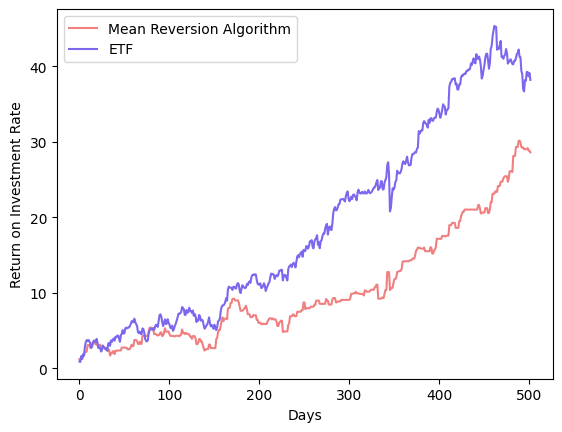

In [196]:
plt.figure()
plt.plot(np.arange(len(RoI_Rate)),RoI_Rate,color="lightcoral")
plt.plot(np.arange(len(etf_RoI_Rate)),etf_RoI_Rate,color="mediumslateblue")
plt.legend(['Mean Reversion Algorithm','ETF'])
plt.xlabel('Days')
plt.ylabel('Return on Investment Rate')
plt.show()